In [283]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [287]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-Library/NPGMI Update.ipynb"

### No Sample

In [252]:
p = 1e-6
L1 = 4
L = 8
Ls = 3.6
mt = 5


polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lam = np.array([5e-10])
plam = np.array([1])

# lam, plam = polyspectrum.copy()

Nbc = 5e28*4.149e-15

h1 = h2 = np.pi/2 / (Nbc*lam[np.argmax(plam)])

phi1 = phi2 =  Nbc*lam * h1

slitx = 200e-6

xbin = 1e-6
ybin = 1e-6

res = 100e-6


dsample = np.linspace(0.25,24.25,97) * p**2/lam[np.argmax(plam)]

npg = 12


r_sphere_vals = np.arange(0.1,5.1,0.1) * p


In [216]:
G1sd = {"p":p, "L1": np.array([L1]), "phi": phi1, "mt":mt, "spectrum_spacing": 1, "n_p_g": npg}
G1sd["L2"] = dsample

G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2, "mt":mt, "spectrum_spacing": 1, "n_p_g": npg}

G2sd["L2"] = np.array([L]) - G2sd["L1"]

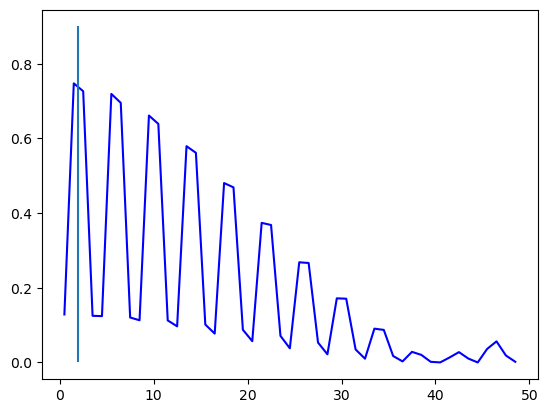

In [139]:

simaptsnosample = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}

siminit = {"lam":lam, "plam":plam, "sum_lam":False, "L":L,"d": dsample  ,"mt":mt, "p" : p,"xbin":xbin,"ybin":ybin ,\
           "convmode" : "valid", "slitx": slitx, "resx": res, "resy":res  }

simnosample = PGMI(simaptsnosample,siminit)

simnosample.propagate_to("G1")
simnosample.propagate_to("G2")

simnosample.generate_after("G2")

# nosample1 = simnosample.contrast
# nosample2 = simnosample.contrast
# nosample3 = simnosample.contrast

nosamplemono = simnosample.contrast
# nosamplepoly = simnosample.contrast


plt.plot(dsample*1e3,simnosample.contrast, "b-")
plt.vlines(p**2/5e-10 * 1e3, 0,0.9)
plt.show()


### With Sample

In [435]:
G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2, "mt":mt, "spectrum_spacing": 1, "n_p_g": npg}


G2sd["L2"] = np.array([L]) - Ls - G2sd["L1"]






r_sphere_vals, lam = force_broadcast(r_sphere_vals,lam)
phi3 = Nbc*lam * r_sphere_vals



# G3sd = {"r_sphere": r_sphere_vals, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "p_g":p, "n_p_g": npg}
G3sd = {"r_sphere": r_sphere_vals, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "p_g":p, "p_s": p_s}


G3sd["L2"] = np.array([L]) - G3sd["L1"] 

In [436]:
t0 = time()

simaptssample = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":SphericalSample(G3sd)}



siminit = {"lam":lam, "plam":plam, "sum_lam":False, "L":L,"d": dsample, "mt":mt, "p" : p,"xbin":xbin,"ybin":ybin ,\
           "convmode" : "valid", "slitx": slitx, "resx": res, "resy":res}

simsample = PGMI(simaptssample,siminit)

simsample.propagate_to("G1")
simsample.propagate_to("G2")
simsample.propagate_to("G3")
simsample.generate_after("G3")


# withsample1 = simsample.contrast
# withsample2 = simsample.contrast
# withsample3 = simsample.contrast
withsamplemono = simsample.contrast
# withsamplepoly = simsample.contrast
lam = assert_ndarr(lam.squeeze())

print(time() - t0, "seconds")


(2, 61, 50) (2, 61)
2.911180019378662 seconds


In [437]:
R_labels = [r"$\frac{p_G}{2}$", r"$p_G$", r"$\frac{3p_G}{2}$", r"$2p_G$",r"$\frac{5p_G}{2}$"]
R_label_locs = np.arange(0.5,3,0.5) * p



d_labels = [r"$\frac{p_G^2}{2\lambda}$", r"$\frac{p_G^2}{\lambda}$",r"$\frac{3p_G^2}{2\lambda}$",\
            r"$\frac{2p_G^2}{\lambda}$",r"$\frac{5p_G^2}{2\lambda}$", r"$\frac{3p_G^2}{\lambda}$",\
            r"$\frac{7p_G^2}{2\lambda}$",r"$\frac{4p_G^2}{\lambda}$"]
d_label_locs = np.arange(0.5,4.5,0.5) * p**2 / lam[np.argmax(plam)]

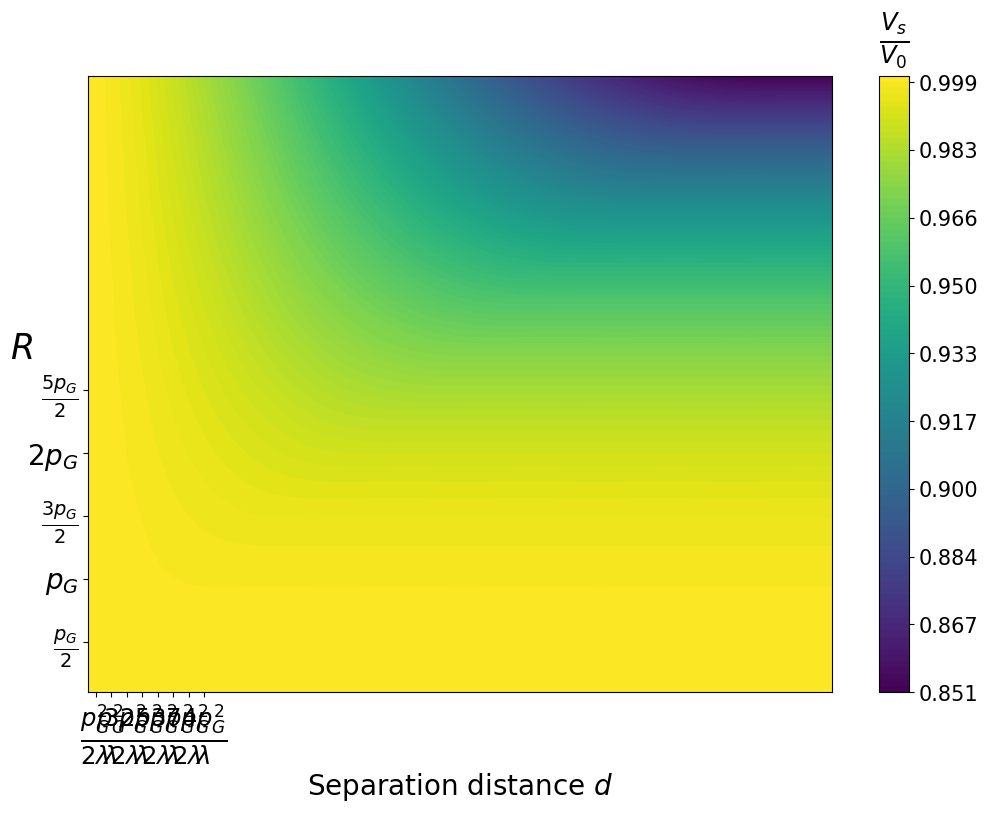

In [438]:
fig, ax = plt.subplots(figsize = (12,8))

contdiv = withsamplemono.T/nosamplemono

# contdiv[contdiv > 1] = 1

c = ax.contourf(contdiv, levels =100,\
            extent = [dsample[0],dsample[-1],r_sphere_vals[0],r_sphere_vals[-1]])
cbar = fig.colorbar(c,format = "%.3f")

cbar.ax.tick_params(labelsize = 15)
cbar.ax.set_title(r"$\frac{V_s}{V_0}$", fontsize = 25, y = 1.03)


ax.set_yticks(R_label_locs)
ax.set_yticklabels(R_labels, fontsize = 20)

ax.set_xticks(d_label_locs)
ax.set_xticklabels(d_labels, fontsize = 25)



ax.set_xlabel("Separation distance $d$", fontsize = 20)
ax.set_ylabel(r"$R$", fontsize = 25, rotation = "horizontal", y=0.53)
# ax.yaxis.set_label_coords(-0.12, 0.5)

# ax.axhline(r_sphere_vals[min_index(contdiv)[0]], color = "r")

# fig.savefig("SpheresDFIMonochromatic.png")

# plt.xlim(1e-2,7e-2)
# plt.ylim(5e-6,10e-6)
plt.show()
plt.close(fig)

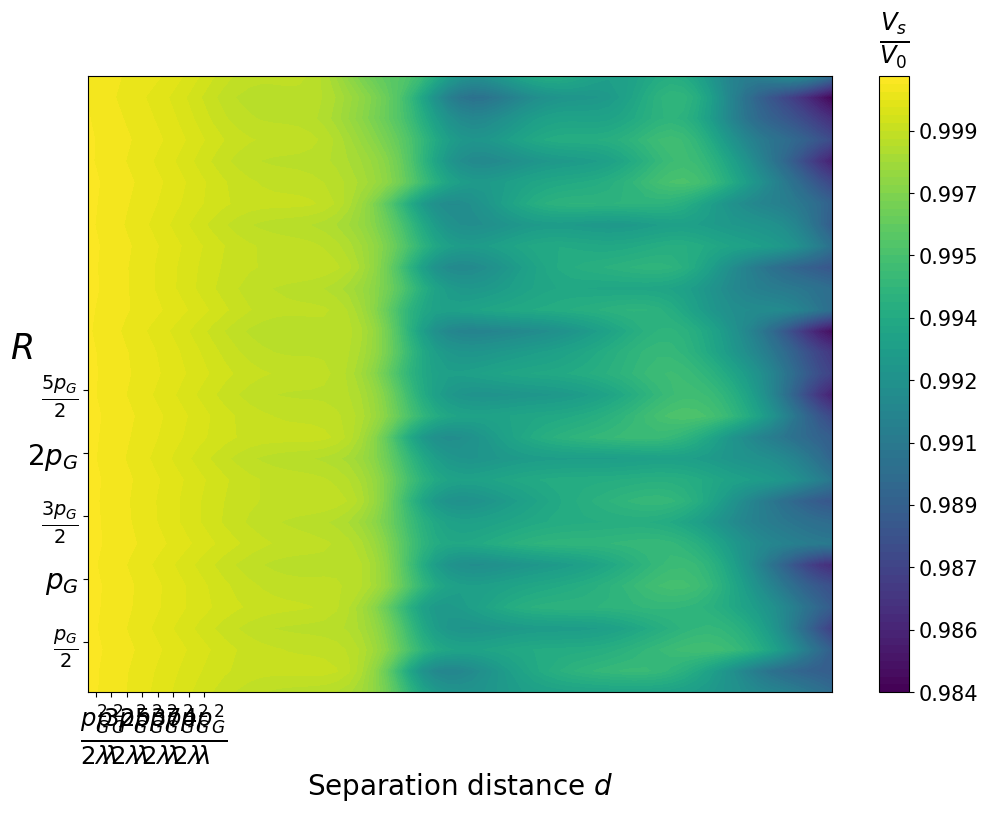

In [439]:
fig, ax = plt.subplots(figsize = (12,8))

contdiv = withsamplepoly.T/nosamplepoly

# contdiv[contdiv > 1] = 1

c = ax.contourf(contdiv, levels = 100,\
            extent = [dsample[0],dsample[-1],r_sphere_vals[0],r_sphere_vals[-1]])
cbar = fig.colorbar(c,format = "%.3f")

cbar.ax.tick_params(labelsize = 15)
cbar.ax.set_title(r"$\frac{V_s}{V_0}$", fontsize = 25, y = 1.03)


ax.set_yticks(R_label_locs)
ax.set_yticklabels(R_labels, fontsize = 20)

ax.set_xticks(d_label_locs)
ax.set_xticklabels(d_labels, fontsize = 25)



ax.set_xlabel("Separation distance $d$", fontsize = 20)
ax.set_ylabel(r"$R$", fontsize = 25, rotation = "horizontal", y=0.53)
# ax.yaxis.set_label_coords(-0.12, 0.5)

# ax.axhline(r_sphere_vals[min_index(contdiv)[0]], color = "r")

fig.savefig("SpheresDFIPolychromatic.png")

# plt.xlim(1e-2,7e-2)
# plt.ylim(5e-6,10e-6)
plt.show()
plt.close(fig)

### Loop over R

In [280]:
t0 = time()



withsamplemonodivcont = []


for i, R in enumerate(r_sphere_vals):
    
    npg = sphere_p_s(R,p,51)/p
#     print("npg:", npg)
    
#     print("R = %.2f um" % (R*1e6))
#     print("p_s = %.2f um" % (npg*p*1e6))
    
    G1sd = {"p":p, "L1": np.array([L1]), "phi": phi1, "mt":mt, "spectrum_spacing": 1, "n_p_g": 50}
    G1sd["L2"] = dsample

    G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2, "mt":mt, "spectrum_spacing": 1, "n_p_g": 50}

    G2sd["L2"] = np.array([L]) - G2sd["L1"]

    simaptsnosample = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}

    siminit = {"lam":lam, "plam":plam, "sum_lam":False, "L":L,"d": dsample  ,"mt":mt, "p" : p,"xbin":xbin,"ybin":ybin ,\
               "convmode" : "valid", "slitx": slitx, "resx": res, "resy":res  }

    simnosample = PGMI(simaptsnosample,siminit)

    simnosample.propagate_to("G1")
    simnosample.propagate_to("G2")

    simnosample.generate_after("G2")


    nosamplemono = simnosample.contrast
    # nosamplepoly = simnosample.contrast
    G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": phi2, "mt":mt, "spectrum_spacing": 1, "n_p_g": 50}


    G2sd["L2"] = np.array([L]) - Ls - G2sd["L1"]






    # r_sphere_vals, lam = force_broadcast(r_sphere_vals,lam)
    phi3 = Nbc*lam * R



    G3sd = {"r_sphere": R, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "p_g":p, "n_p_g": npg}


    G3sd["L2"] = np.array([L]) - G3sd["L1"] 



    simaptssample = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":SphericalSample(G3sd)}



    siminit = {"lam":lam, "plam":plam, "sum_lam":False, "L":L,"d": dsample, "mt":mt, "p" : p,"xbin":xbin,"ybin":ybin ,\
               "convmode" : "valid", "slitx": slitx, "resx": res, "resy":res}

    simsample = PGMI(simaptssample,siminit)

    simsample.propagate_to("G1")
    simsample.propagate_to("G2")
    simsample.propagate_to("G3")
    simsample.generate_after("G3")


    withsamplemono = simsample.contrast
    # plt.plot(nosamplemono)
    # plt.show()
    # withsamplepoly = simsample.contrast

    withsamplemonodivcont.append(withsamplemono/nosamplemono)
    
print(time() - t0, "seconds")


(97, 9, 11, 11) (97, 9, 11, 11) (97,) (97,) (1,)
(97, 5, 11, 11) (97, 5, 11, 11) (97,) (97,) (1,)
(97, 3, 11, 11) (97, 3, 11, 11) (97,) (97,) (1,)
(97, 405, 11, 11) (97, 405, 11, 11) (97,) (97,) (1,)
(97, 289, 11, 11) (97, 289, 11, 11) (97,) (97,) (1,)
(97, 293, 11, 11) (97, 293, 11, 11) (97,) (97,) (1,)
(97, 281, 11, 11) (97, 281, 11, 11) (97,) (97,) (1,)
(97, 269, 11, 11) (97, 269, 11, 11) (97,) (97,) (1,)
(97, 257, 11, 11) (97, 257, 11, 11) (97,) (97,) (1,)
(97, 259, 11, 11) (97, 259, 11, 11) (97,) (97,) (1,)
(97, 251, 11, 11) (97, 251, 11, 11) (97,) (97,) (1,)
(97, 245, 11, 11) (97, 245, 11, 11) (97,) (97,) (1,)
(97, 241, 11, 11) (97, 241, 11, 11) (97,) (97,) (1,)
(97, 247, 11, 11) (97, 247, 11, 11) (97,) (97,) (1,)
(97, 237, 11, 11) (97, 237, 11, 11) (97,) (97,) (1,)
(97, 243, 11, 11) (97, 243, 11, 11) (97,) (97,) (1,)
(97, 233, 11, 11) (97, 233, 11, 11) (97,) (97,) (1,)
(97, 231, 11, 11) (97, 231, 11, 11) (97,) (97,) (1,)
(97, 227, 11, 11) (97, 227, 11, 11) (97,) (97,) (1,)
(97, 

In [281]:
withsamplemonodivcont = np.squeeze(withsamplemonodivcont)
withsamplemonodivcont.shape

(50, 97)

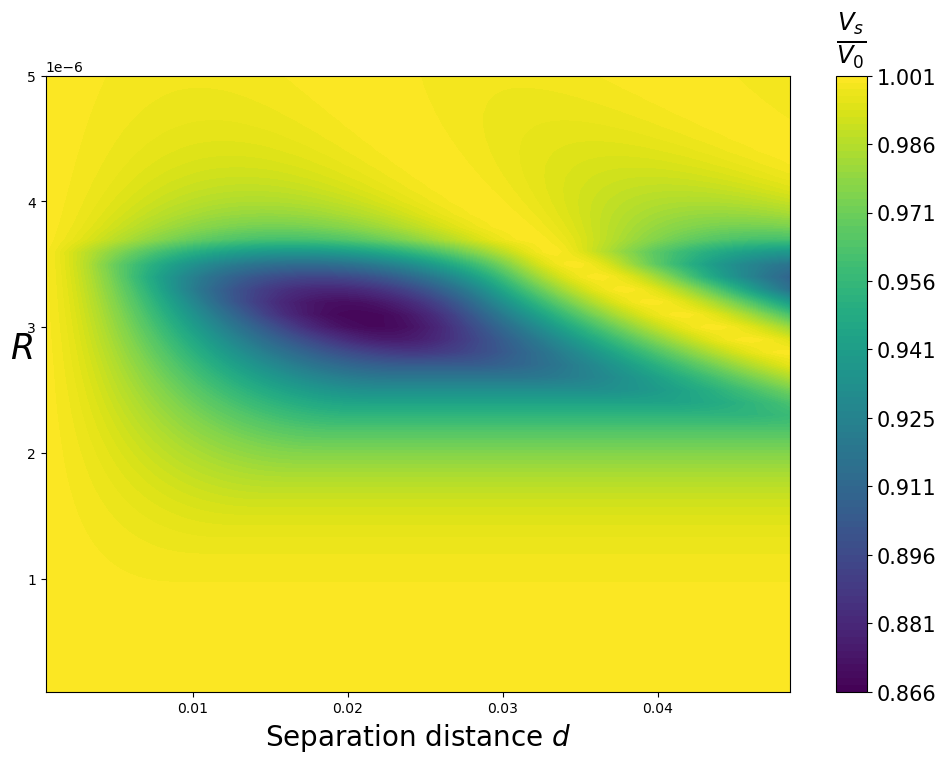

In [282]:
fig, ax = plt.subplots(figsize = (12,8))


# contdiv[contdiv > 1] = 1

c = ax.contourf(withsamplemonodivcont, levels =100,\
            extent = [dsample[0],dsample[-1],r_sphere_vals[0],r_sphere_vals[-1]])
cbar = fig.colorbar(c,format = "%.3f")

cbar.ax.tick_params(labelsize = 15)
cbar.ax.set_title(r"$\frac{V_s}{V_0}$", fontsize = 25, y = 1.03)


# ax.set_yticks(R_label_locs)
# ax.set_yticklabels(R_labels, fontsize = 20)

# ax.set_xticks(d_label_locs)
# ax.set_xticklabels(d_labels, fontsize = 25)



ax.set_xlabel("Separation distance $d$", fontsize = 20)
ax.set_ylabel(r"$R$", fontsize = 25, rotation = "horizontal", y=0.53)
# ax.yaxis.set_label_coords(-0.12, 0.5)

# ax.axhline(r_sphere_vals[min_index(contdiv)[0]], color = "r")

# fig.savefig("SpheresDFIMonochromatic.png")

# plt.xlim(1e-2,7e-2)
# plt.ylim(5e-6,10e-6)
plt.show()
plt.close(fig)

In [263]:
r_p_mult_ind = np.argmin(np.abs(r_sphere_vals.squeeze()[None,:] - np.arange(0.5,5.5,0.5)[:,None]*p),axis = 1)

In [264]:
[r_sphere_vals[i] for i in r_p_mult_ind]

[5e-07,
 1e-06,
 1.5000000000000002e-06,
 2e-06,
 2.5e-06,
 3.0000000000000005e-06,
 3.5000000000000004e-06,
 4e-06,
 4.5e-06,
 4.9999999999999996e-06]

In [278]:

xi = lam[np.argmax(plam)]*Ls*dsample/(L*p)

# xi_labels = [r"$\frac{p_G}{2}$", r"$p_G$",r"$\frac{3p_G}{2}$"]
xi_labels = [r"$p_G$",r"$2p_G$",r"$3p_G$",r"$4p_G$",r"$5p_G$",r"$6p_G$",r"$7p_G$"]

xi_label_locs = np.arange(1,8,1) * p

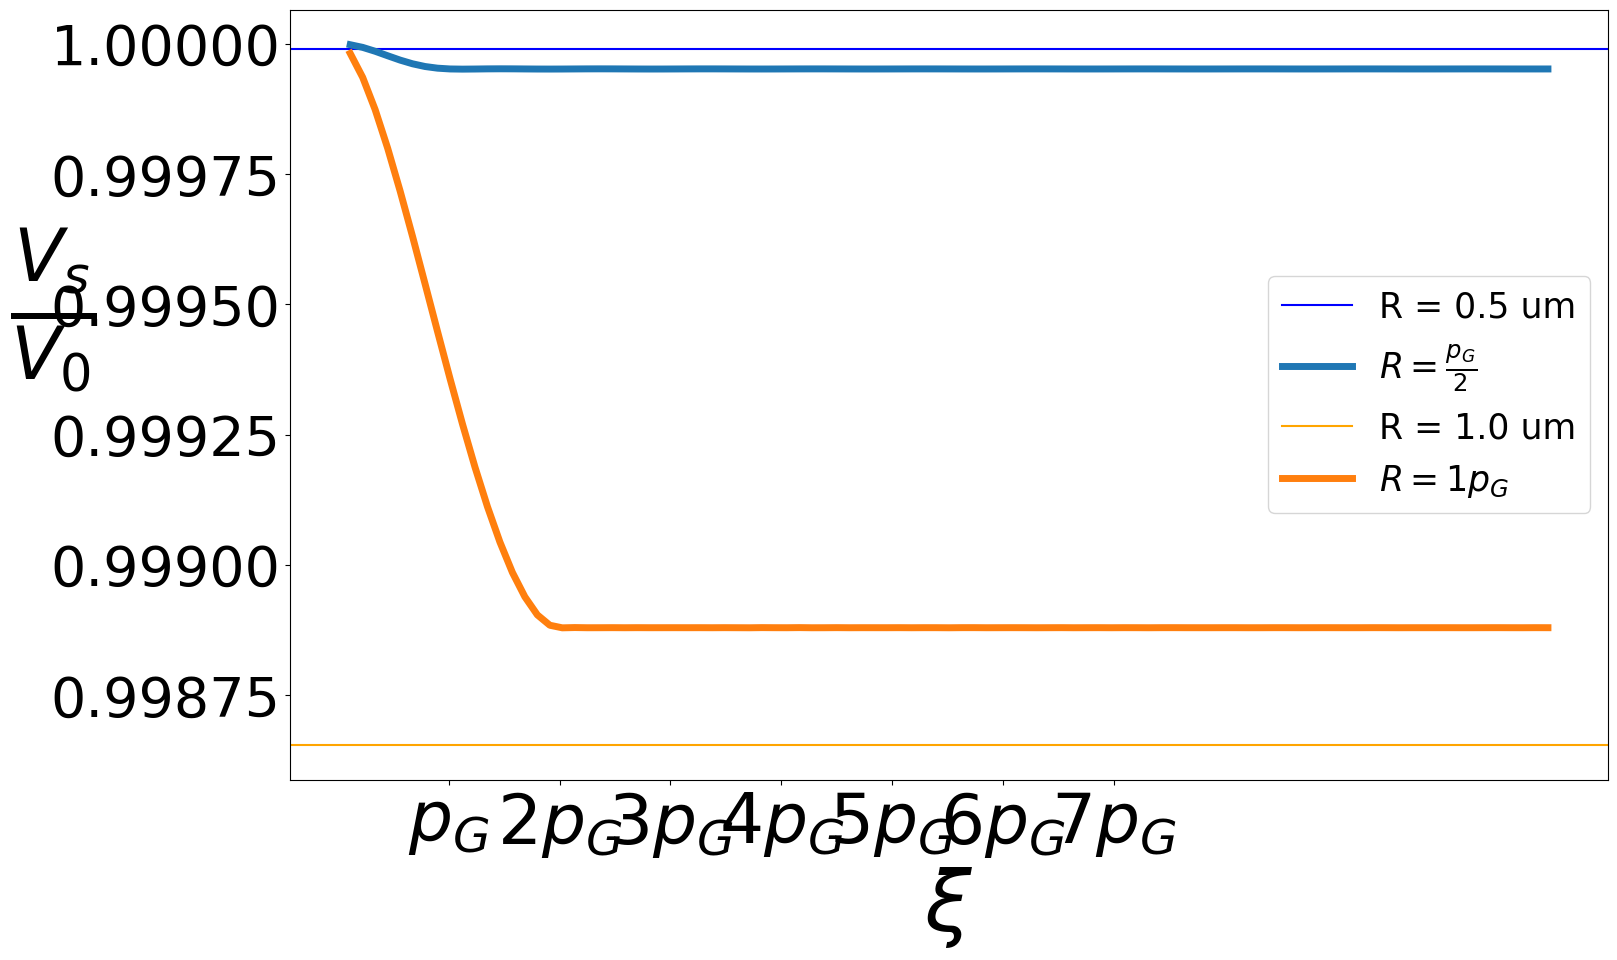

In [303]:
fig, ax1 = plt.subplots(figsize = (17,10))

colors =["blue", "orange", "green", "red", "purple", "brown","teal", "pink", "yellow"]

# R = 1.1*r_sphere_vals[r_p_mult_ind]
# c = [pi/1057,pi/133 , pi/39.8 , pi/17.1, pi/9, pi/5.38, pi /3.5]


for count, i in enumerate(r_p_mult_ind[:2]):
    p_s = sphere_p_s(r_sphere_vals[i],p,4)
    ax1.axhline(1 - (2 * r_sphere_vals[i]**4 * (Nbc*lam)**2 / (p_s**2)),\
                label = "R = %.1f um" % (r_sphere_vals[i] *1e6), color = colors[count])
    if count == 0:
        ax1.plot(xi, withsamplemonodivcont[i],\
             label = r"$R = \frac{p_G}{2}$", lw = 5)
    elif count % 2 != 0:
        ax1.plot(xi, withsamplemonodivcont[i],\
             label = r"$R = %dp_G$" % ((count + 1)//2), lw = 5)
    else:
        ax1.plot(xi, withsamplemonodivcont[i],\
             label = r"$R = \frac{%dp_G}{2}$" % (count + 1), lw = 5)


# for count, i in enumerate(r_p_mult_ind[3:4]):
#     ax1.plot(xi, (withsample1[...,i]/nosample1),\
#              label = r"$p_s = 10p_g, r_{sphere} = %dp_g$" % (count + 1)) #, color = colors[count])

    
# ax1.set_prop_cycle(None)
# for count, i in enumerate(r_p_mult_ind[3:4]):
#     ax1.plot(xi, (withsample2[...,i]/nosample2),\
#              "--", label = r"$p_s = 20p_g, r_{sphere} = %dp_g$" % (count + 1)) #, color = colors[count])


# ax1.set_prop_cycle(None)
# for count, i in enumerate(r_p_mult_ind):
#     ax1.plot(xi, (withsample3[...,i]/nosample3),\
#              "--", label = r"$p_s = 30p_g, r_{sphere} = %dp_g$" % (count + 1)) #, color = colors[count])

# ax1.set_prop_cycle(None)

# for i, r in enumerate(R):
#     ax1.plot(xi, 1 - 2*c[i]/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),r)), ".")
    # ax1.plot(xi, 1 - 2*c[2*i+1]/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),r)), ".-")

    
# ax1.plot(xi, 1 - 2*c1/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R1)), ".-")
# ax1.plot(xi, 1 - 2*c2/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R1)), ".-")

# ax1.plot(xi, 1 - 2*c3/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R2)), ".-")
# ax1.plot(xi, 1 - 2*c4/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R2)), ".-")

# ax1.plot(xi, 1 - 2*c5/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R3)), ".-")
# ax1.plot(xi, 1 - 2*c6/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R3)), ".-")

# ax1.plot(xi, 1 - 2*c7/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R4)), ".-")
# ax1.plot(xi, 1 - 2*c8/pi * (1 - sphere_autocorrelation_func(xi.astype(complex),R4)), ".-")


ax1.set_ylabel(r"$\frac{V_s}{V_0}$", fontsize =75, rotation = "horizontal")
ax1.yaxis.set_label_coords(-0.18, 0.5)
ax1.tick_params(labelsize = 40)


ax1.set_xlabel(r"$\xi$", fontsize = 60)
ax1.set_xticks(xi_label_locs)
ax1.set_xticklabels(xi_labels, fontsize = 50)


ax1.legend(fontsize = 25)

plt.show()
plt.close(fig)

NameError: name 'r_p_mult_ind' is not defined

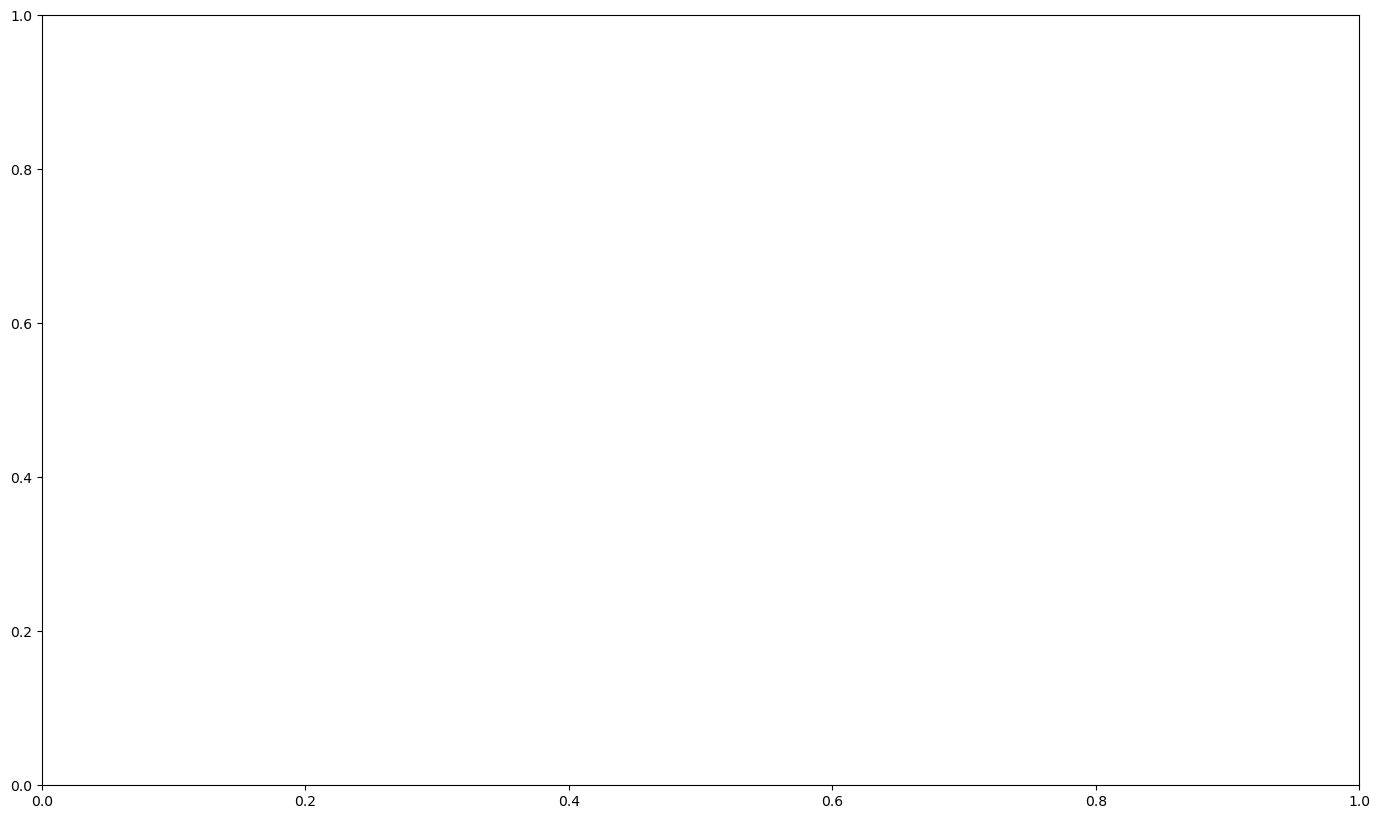

In [12]:
fig, ax1 = plt.subplots(figsize = (17,10))



for count, i in enumerate(r_p_mult_ind):
    if count == 0:
        ax1.plot(xi, (withsamplepoly[...,i]/nosamplepoly),\
             label = r"$R = \frac{p_G}{2}$", lw = 5)
    elif count % 2 != 0:
        ax1.plot(xi, (withsamplepoly[...,i]/nosamplepoly),\
             label = r"$R = %dp_G$" % (count + 1), lw = 5)
    else:
        ax1.plot(xi, (withsamplepoly[...,i]/nosamplepoly),\
             label = r"$R = \frac{%dp_G}{2}$" % (count + 1), lw = 5)




ax1.set_ylabel(r"$\frac{V_s}{V_0}$", fontsize =75, rotation = "horizontal")
ax1.yaxis.set_label_coords(-0.18, 0.5)
ax1.tick_params(labelsize = 40)


ax1.set_xlabel(r"$\xi$", fontsize = 60)
ax1.set_xticks(xi_label_locs)
ax1.set_xticklabels(xi_labels, fontsize = 50)


ax1.legend(fontsize = 25)

plt.show()
plt.close(fig)